# 「ベイズ推論による機械学習入門」
# P.149 ガウス混合モデルにおける変分推論

In [1]:
using Distributions
using LinearAlgebra
using PDMats
using Plots
using StatsBase
using SpecialFunctions: digamma

const ψ = digamma

digamma (generic function with 2 methods)

# 真のモデル

In [2]:
D = 2
K = 3

μ₁ = [5.0; 35.0]
μ₂ = [-40.0; 10.0]
μ₃ = [30.0; -20.0]

Σ₁ = [
    250.0 65.0
    65.0 270.0
]

Σ₂ = [
    125.0 -45.0
    -45.0 175.0
]

Σ₃ = [
    210.0 -15.0
    -15.0 250.0
]


π₁ = 0.45
π₂ = 0.25
π₃ = 0.3

μ⃗ = [μ₁, μ₂, μ₃]

Σ⃗ = [Σ₁, Σ₂, Σ₃]

𝒩 = MvNormal[
        MvNormal(μ₁, Σ₁),
        MvNormal(μ₂, Σ₂),
        MvNormal(μ₃, Σ₃),
]

g_mixture = MixtureModel(𝒩, [π₁, π₂, π₃]);

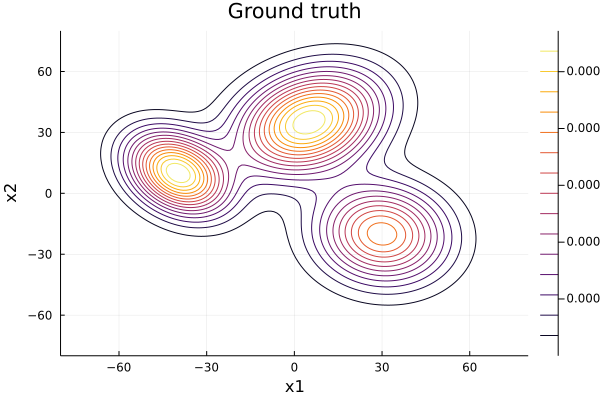

In [3]:
xrange = -80:80
cplot = contour(
    xrange, xrange, (x, y)->pdf(g_mixture, [x, y]),
    title="Ground truth",
    xlabel = "x1",
    ylabel = "x2",
)

# 観測データの生成

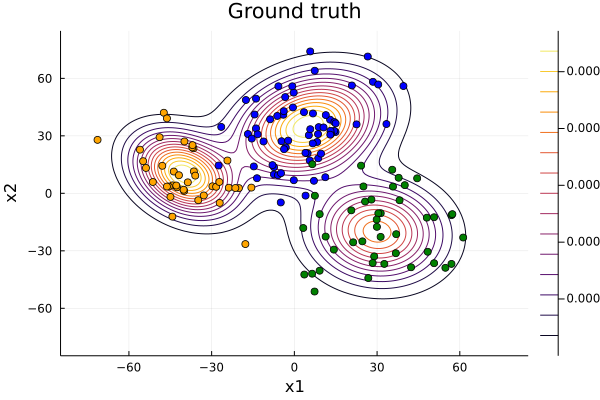

In [4]:
N = 150
observations = rand(Multinomial(1, [π₁, π₂, π₃]), N)
categories = mapslices(argmax, observations, dims=1)

data = zeros(N, D)

colors = [:blue, :orange, :green]

for n in 1:N
    k = categories[n]
    x, y = data[n, :] = rand(𝒩[k])
    scatter!(cplot, [x], [y], color=colors[k], label=false)
end

cplot

# 変分推論

In [13]:
# μの事前分布のパラメータを設定
β = 1.0
m = zeros(D)

# λの事前分布のパラメータを設定
W = Matrix(1.0I, D, D)
ν = D

# πの事前分布のパラメータを設定
α = [2., 2., 2.];

In [24]:
# 潜在変数の近似事後分布q(S)の期待値を初期化
_E_S = rand(Uniform(0, 1), N, K)
E_S = _E_S ./ sum(_E_S, dims=2) # 正規化
E_S[1:5, :]

5×3 Matrix{Float64}:
 0.347717  0.311106  0.341177
 0.251735  0.338913  0.409352
 0.382112  0.232415  0.385472
 0.321507  0.233177  0.445316
 0.313968  0.487811  0.198221

In [ ]:
# 初期値による近似事後分布q(μ)のパラメータを計算
